В нашей игре проводился А/В тест. Каждый игрок был распределен в одну из групп (контрольная или тестовая) и получил идентификатор 0 или 1 соответственно. В тесте мы хотели проверить гипотезу о том, что изменения в тестовой группе положительно повлияют на денежные показатели: ARPU, ARPPU и конверсию. Проведите анализ А/В теста. Данные можно по ссылке. Данные содержат следующие поля:
- geo_country - страна игрока
- test_timestamp - дата, когда игрок попал в тест
- user_revenue - выручка с игрока
- user_payments - количество платежей игрока
- user_id - идентификатор игрока
- test_group - идентификатор группы теста

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

from tqdm.auto import tqdm
from statsmodels.stats.proportion import proportions_ztest

from statsmodels.stats.multitest import multipletests

In [2]:
data = pd.read_csv("data.csv", parse_dates=['test_timestamp'])
data.head()

,geo_country,test_timestamp,user_revenue,user_payments,user_id,test_group
0,Russia,2021-05-03 19:06:06.325,NaN,0,6d696b2e-f236-45b1-b770-5530b2a3b3cf,0
1,India,2021-05-04 17:13:35.877,NaN,0,3ae8cd76-14ef-4e47-99c9-637e9260205e,0
2,Russia,2021-05-01 01:56:49.796,1.223728,1,0bf7d591-a052-44a2-97a5-161791fb440d,0
3,Kazakhstan,2021-05-03 04:17:25.337,NaN,0,5f8a3459-e85d-451e-8f93-0c17664c70da,0
4,Switzerland,2021-05-20 10:49:18.064,NaN,0,f2ea93ed-b9c6-4d8b-88d0-7717f8931988,0


Проверим и подготовим данные:

In [3]:
data.shape

(91000, 6)

In [4]:
data.dtypes

geo_country               object
test_timestamp    datetime64[ns]
user_revenue             float64
user_payments              int64
user_id                   object
test_group                 int64
dtype: object

In [5]:
data.isna().sum()

geo_country          18
test_timestamp        0
user_revenue      84268
user_payments         0
user_id               0
test_group            0
dtype: int64

In [6]:
data.user_revenue.fillna(0, inplace=True)

In [7]:
data.query('geo_country.isna()')          

,geo_country,test_timestamp,user_revenue,user_payments,user_id,test_group
4902,NaN,2021-05-02 12:11:40.675,0.0,0,062de72d-e68d-4958-b88e-2a543fbbb855,0
8626,NaN,2021-05-12 19:42:49.208,0.0,0,c810d2ae-9019-4cc0-b679-fe670c5260c4,0
11199,NaN,2021-05-23 19:01:09.719,0.0,0,1e40be1a-53f9-498b-ab78-9428f2add58e,0
16257,NaN,2021-05-01 17:12:02.575,0.0,0,9f9adafe-4a9f-4de9-ada4-8c0e659c81cd,0
19005,NaN,2021-05-09 12:07:41.241,0.0,0,e680ac0e-1597-442b-bcc9-676864f0e1be,0
19637,NaN,2021-05-31 11:15:44.431,0.0,0,ca31453d-1692-4bda-93dd-85e43e5557d9,0
25156,NaN,2021-05-28 18:41:37.086,0.0,0,1fa38c62-170b-4d0e-b13b-53cdf25f3238,1
26030,NaN,2021-05-23 13:00:28.796,0.0,0,d2d25be9-e100-4d82-84fc-6d4c876ce7b7,1
26778,NaN,2021-05-03 13:30:33.213,0.0,0,e941c812-923d-4eb8-9993-e3afddb58e32,1
33186,NaN,2021-05-01 10:14:17.297,0.0,0,f17724c7-ec1e-4bf4-9672-6e68951c3c36,1


In [8]:
data.user_id.nunique()

91000

In [9]:
data['mean_revenue_per_transact'] = data['user_revenue'] / data['user_payments']
data['is_client'] = (data['user_payments'] >= 1).astype(int) #  т.к. могут возникнуть проблемы при агрегации
data.mean_revenue_per_transact.fillna(0, inplace=True)
data.head()

,geo_country,test_timestamp,user_revenue,user_payments,user_id,test_group,mean_revenue_per_transact,is_client
0,Russia,2021-05-03 19:06:06.325,0.000000,0,6d696b2e-f236-45b1-b770-5530b2a3b3cf,0,0.000000,0
1,India,2021-05-04 17:13:35.877,0.000000,0,3ae8cd76-14ef-4e47-99c9-637e9260205e,0,0.000000,0
2,Russia,2021-05-01 01:56:49.796,1.223728,1,0bf7d591-a052-44a2-97a5-161791fb440d,0,1.223728,1
3,Kazakhstan,2021-05-03 04:17:25.337,0.000000,0,5f8a3459-e85d-451e-8f93-0c17664c70da,0,0.000000,0
4,Switzerland,2021-05-20 10:49:18.064,0.000000,0,f2ea93ed-b9c6-4d8b-88d0-7717f8931988,0,0.000000,0


In [10]:
data.user_revenue.sort_values()

0          0.000000
59575      0.000000
59574      0.000000
59573      0.000000
59572      0.000000
            ...    
3903     105.543209
38880    111.998889
50841    115.932887
16360    124.925704
37698    175.936684
Name: user_revenue, Length: 91000, dtype: float64

In [11]:
data.mean_revenue_per_transact.sort_values()

0         0.000000
59575     0.000000
59574     0.000000
59573     0.000000
59572     0.000000
           ...    
90584    18.438978
75782    18.460139
53414    19.798927
82308    21.027730
79982    23.925510
Name: mean_revenue_per_transact, Length: 91000, dtype: float64

In [12]:
# подготовим данные и соберем полученную информацию в таблицу для наглядности

control = data.query('test_group == 0')
test = data.query('test_group == 1')

# количество пользователей в группах
users_quantity_control = control.shape[0]
users_quantity_test = test.shape[0]

# выручка
total_user_revenue_control =  control.user_revenue.sum()
total_user_revenue_test =  test.user_revenue.sum()

# количество покупок в группах
checks_control_quantity = control.query('user_revenue > 0').shape[0]
checks_test_quantity = test.query('user_revenue > 0').shape[0]

# количество клиентов в группах
clients_control_quantity = control.query('user_revenue > 0').user_id.nunique()
clients_test_quantity = test.query('user_revenue > 0').user_id.nunique()
    
# конверсия в покупателя
cr_control = round(clients_control_quantity / users_quantity_control * 100, 2)
cr_test = round(clients_test_quantity / users_quantity_test * 100 , 2)
         
# ARPU
arpu_control = round(control.user_revenue.sum() / control.shape[0], 6)
arpu_test = round(test.user_revenue.sum() / test.shape[0], 6)

# ARPPU
arppu_control = round(control.user_revenue.sum() / clients_control_quantity, 6)
arppu_test = round(test.user_revenue.sum() / clients_test_quantity, 6)

# Средний чек
avg_check_control = round(np.mean(control.query('user_revenue > 0').user_revenue / control.user_payments), 6)
avg_check_test = round(np.mean(test.query('user_revenue > 0').user_revenue / test.user_payments), 6)
    
# коэффициент повторных покупок
rep_purch_control = round(control.query('user_revenue > 0').user_payments.mean(), 2)
rep_purch_test = round(test.query('user_revenue > 0').user_payments.mean(), 2)

metrics = pd.DataFrame({'group': ["control", "test"],
                        'users': [users_quantity_control, users_quantity_test],
                        'clients': [clients_control_quantity, clients_test_quantity],
                        'total_user_revenue': [total_user_revenue_control, total_user_revenue_test],
                        'CR': [cr_control, cr_test],
                        'arpu': [arpu_control, arpu_test],
                        'arppu': [arppu_control, arppu_test],
                        'avg_check': [avg_check_control, avg_check_test],
                        'rep_purch': [rep_purch_control, rep_purch_test]}
                          )

metrics = metrics.set_index("group").T

metrics['diff'] = metrics['test'] - metrics['control']
metrics['percent_diff'] = round(metrics['diff'] / metrics['control'] * 100, 2)
metrics

group,control,test,diff,percent_diff
users,45400.000000,45600.000000,200.000000,0.44
clients,3489.000000,3243.000000,-246.000000,-7.05
total_user_revenue,17001.593107,16090.426997,-911.166110,-5.36
CR,7.690000,7.110000,-0.580000,-7.54
arpu,0.374484,0.352860,-0.021624,-5.77
arppu,4.872913,4.961587,0.088674,1.82
avg_check,1.412182,1.452366,0.040184,2.85
rep_purch,3.510000,3.420000,-0.090000,-2.56


- Суммарная выручка в тестовой группе меньше, чем в контрольной на 5.36%;
- При этом конверсия в платеж тестовой группы пользователей снизилась на ~7.54% относительно контрольной;
- ARPU в тестовой группе ниже на ~5.77%;
- ARPPU в тестовой группе превосходит аналогичный показатель в контрольной - разница в ~1.82%;
- Cредний чек в тестовой группе дороже на ~2.85%;
- Коэффициент повторных покупок снизился на 2.56%.

Перед воспроизведением A/B-теста проверим распределения user_revenue на нормальность тестом Шапиро-Уилка.:

ShapiroResult(statistic=0.12578243017196655, pvalue=0.0)
2.8038017214413613


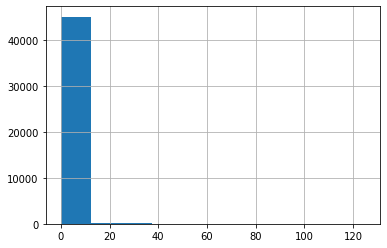

In [13]:
control.user_revenue.hist()
print(stats.shapiro(control.user_revenue.sample(1000, random_state=17)))
print(np.std(control.user_revenue))

ShapiroResult(statistic=0.10272377729415894, pvalue=0.0)
2.8066762535148264


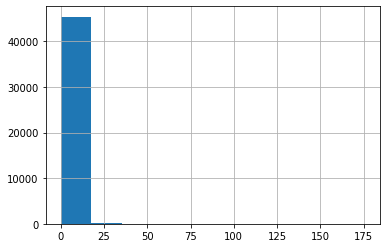

In [14]:
test.user_revenue.hist()
print(stats.shapiro(test.user_revenue.sample(1000, random_state=17)))
print(np.std(test.user_revenue))

В обоих случаях распределения не являются нормальными (p-value < 0.05)

Проверим статистическую значимость различий между группами эксперимента.
Т.к. распределения нормальными не являются, воспользуемся бутстрэпом:

In [15]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    return {"ci": ci, 
            "p_value": p_value}

#### ARPU:

In [16]:
get_bootstrap(control.user_revenue, test.user_revenue)

  0%|          | 0/2000 [00:00<?, ?it/s]

{'ci':               0
 0.025 -0.012820
 0.975  0.058663,
 'p_value': 0.23258950126576494}

#### ARRPU:

In [17]:
get_bootstrap(control.query('user_revenue > 0').user_revenue, test.query('user_revenue > 0').user_revenue)

  0%|          | 0/2000 [00:00<?, ?it/s]

{'ci':               0
 0.025 -0.524419
 0.975  0.370630,
 'p_value': 0.7186447402761675}

#### CR:

In [18]:
# для этой цели воспользуемся proportions_ztest
count = np.array([control.query('user_revenue > 0').user_id.nunique(), test.query('user_revenue > 0').user_id.nunique()])
nobs = np.array([control.user_id.nunique(), test.user_id.nunique()])
z,p = proportions_ztest(count, nobs, value=0, alternative='two-sided')
print('z-stat = {z} \n p-value = {p}'.format(z=z,p=p))

z-stat = 3.303076372302363 
 p-value = 0.0009563033912928121


##### По результатам proportions_ztest обнаружены стат.значимые различия в конверсии контрольной и тестовой групп. 

In [19]:
metrics

group,control,test,diff,percent_diff
users,45400.000000,45600.000000,200.000000,0.44
clients,3489.000000,3243.000000,-246.000000,-7.05
total_user_revenue,17001.593107,16090.426997,-911.166110,-5.36
CR,7.690000,7.110000,-0.580000,-7.54
arpu,0.374484,0.352860,-0.021624,-5.77
arppu,4.872913,4.961587,0.088674,1.82
avg_check,1.412182,1.452366,0.040184,2.85
rep_purch,3.510000,3.420000,-0.090000,-2.56


#### Конверсия в покупку стат.значимо больше в контрольной группе, при этом о стат.значимой разнице в значениях ARPU и ARPPU мы такого утверждать не можем.

Проанализируем эти метрики для каждой страны отдельно. 

Рассчитаем разницу СR по странам и попытаемся оценить, являются ли полученные различия стат.значимыми. 

In [20]:
data['is_client'] = (data['user_payments'] >= 1).astype(int)

users_by_countries = (
    data
    .groupby(['geo_country', 'test_group'], as_index=False)
    .agg({'user_id':'nunique', 'is_client' : 'sum'})
    .pivot(index='geo_country', columns='test_group', values=['user_id', 'is_client'])
    .reset_index()
    )

users_by_countries.columns = ['country', 'control_users', 'test_users', 'control_clients', 'test_clients']
users_by_countries['control_CR'] = round(users_by_countries['control_clients'] / users_by_countries['control_users'] * 100, 2)
users_by_countries['test_CR'] = round(users_by_countries['test_clients'] / users_by_countries['test_users'] * 100, 2)
users_by_countries['CR_diff'] = users_by_countries['test_CR'] - users_by_countries['control_CR']
users_by_countries['CR_percent_diff'] = round(users_by_countries['CR_diff'] / users_by_countries['control_CR'] * 100, 2)
users_by_countries.sample(10)

,country,control_users,test_users,control_clients,test_clients,control_CR,test_CR,CR_diff,CR_percent_diff
27,Brunei,23.0,27.0,1.0,0.0,4.35,0.00,-4.35,-100.00
143,Norway,243.0,235.0,30.0,26.0,12.35,11.06,-1.29,-10.45
179,St. Martin,1.0,2.0,0.0,0.0,0.00,0.00,0.00,NaN
196,Turkey,761.0,776.0,28.0,32.0,3.68,4.12,0.44,11.96
50,Czechia,155.0,192.0,8.0,8.0,5.16,4.17,-0.99,-19.19
128,Monaco,1.0,2.0,0.0,0.0,0.00,0.00,0.00,NaN
181,St. Vincent & Grenadines,2.0,NaN,0.0,NaN,0.00,NaN,NaN,NaN
8,Armenia,NaN,5.0,NaN,0.0,NaN,0.00,NaN,NaN
99,Kazakhstan,374.0,378.0,6.0,6.0,1.60,1.59,-0.01,-0.63
89,Indonesia,790.0,748.0,23.0,25.0,2.91,3.34,0.43,14.78


In [21]:
CR_test_countries = pd.DataFrame(columns=['metric', 'country','CR_percent_diff', 'p_alpha', 'p_value'])
def get_ztest_for_CR(df):
    
    global CR_test_countries
    
    for i in users_by_countries['country']:
        
        count_control = df.query('country in @i').control_clients
        count_test = df.query('country in @i').test_clients
        nobs_control = df.query('country in @i').control_users
        nobs_test = df.query('country in @i').test_users
        
        count = np.array([count_control, count_test])
        nobs = np.array([nobs_control, nobs_test])
        z,p = proportions_ztest(count, nobs, value=0, alternative='two-sided')
        
        CR_percent_diff = df.query('country == @i').iloc[0]['CR_percent_diff']
        
        
        new_row = {'metric': 'CR',
                   'country': i,
                   'CR_percent_diff': CR_percent_diff,
                   'p_alpha': 0.05,
                   'p_value': p.round(6)
                  }
        
        CR_test_countries = CR_test_countries.append([new_row])
    return CR_test_countries

In [22]:
get_ztest_for_CR(users_by_countries)

C:\Users\AM\miniforge3\lib\site-packages\statsmodels\stats\weightstats.py:790: RuntimeWarning: invalid value encountered in true_divide
  zstat = value / std


,metric,country,CR_percent_diff,p_alpha,p_value
0,CR,Afghanistan,NaN,0.05,[nan]
0,CR,Albania,NaN,0.05,[nan]
0,CR,Algeria,NaN,0.05,[nan]
0,CR,American Samoa,NaN,0.05,[nan]
0,CR,Andorra,NaN,0.05,[nan]
...,...,...,...,...,...
0,CR,Western Sahara,NaN,0.05,[nan]
0,CR,Yemen,NaN,0.05,[nan]
0,CR,Zambia,-100.0,0.05,[0.389424]
0,CR,Zimbabwe,NaN,0.05,[nan]


In [23]:
got_diff = CR_test_countries.query('p_value < 0.05')
got_diff

,metric,country,CR_percent_diff,p_alpha,p_value
0,CR,France,-36.31,0.05,[0.014864]
0,CR,Guadeloupe,-100.00,0.05,[0.033028]
0,CR,Ireland,-67.35,0.05,[0.048576]


In [24]:
users_by_countries.query('country in @got_diff.country')

,country,control_users,test_users,control_clients,test_clients,control_CR,test_CR,CR_diff,CR_percent_diff
65,France,2481.0,1091.0,125.0,35.0,5.04,3.21,-1.83,-36.31
77,Guadeloupe,50.0,43.0,5.0,0.0,10.00,0.00,-10.00,-100.00
92,Ireland,106.0,65.0,15.0,3.0,14.15,4.62,-9.53,-67.35


#### Можно сделать вывод, что CR стат.значимо различается во Франции, Гваделупе и Ирландии, во всех трех случаях в пользу контрольной группы.

Проанализируем ARPU и ARPPU по странам и попытаемся ценить, являются ли полученные различия стат.значимыми.

In [25]:
# исключим страны с малым (недостаточным) количеством наблюдений
users_by_countries = users_by_countries.query('control_users >= 30 and test_users >= 30 and control_clients >= 2 and test_clients >= 2')
users_by_countries.shape[0]

51

In [26]:
AB_countries = pd.DataFrame(columns=['metric', 'country','ci_0.025', 'ci_0.0975', 'p_alpha', 'p_value'])

# зададим функцию для автоматизации тестов

def AB_by_country(metric):
    
    global AB_countries
    
    for i in users_by_countries['country']:
        s1 = control.query(metric)['user_revenue']
        s2 = test.query(metric)['user_revenue']
        
        boot_data_mean = get_bootstrap(s2, s1)
        
        p_value = boot_data_mean['p_value']
        ci_0025 = boot_data_mean["ci"].reset_index().loc[0][0]
        ci_0975 = boot_data_mean["ci"].reset_index().loc[1][0]
        
        new_row = {'metric': metric,
                   'country': i,
                   'ci_0.025': ci_0025,
                   'ci_0.0975': ci_0975,
                   'p_alpha': 0.05,
                   'p_value': p_value
                  }
        
        AB_countries = AB_countries.append([new_row])
        
AB_countries = AB_countries.replace(['geo_country in @i', 'geo_country in @i and user_revenue > 0'], ['ARPU', 'ARPPU'])

In [27]:
# тест ARPU
AB_by_country('geo_country in @i')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [28]:
# тест ARPPU
AB_by_country('geo_country in @i and user_revenue > 0')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [29]:
AB_countries = AB_countries.replace(['geo_country in @i', 'geo_country in @i and user_revenue > 0'], ['ARPU', 'ARPPU'])

In [30]:
# применяем поправку Шидака-Холма для снижения вероятности допустить ошибку первого рода.
reject, p_value_corrected, sidak_corr, bonf_corr = multipletests(AB_countries.p_value, alpha=0.05, method='Holm-Sidak')
AB_countries['Holm-Sidak Correction Result'] = reject

In [31]:
AB_countries.query('metric == "ARPU"')

,metric,country,ci_0.025,ci_0.0975,p_alpha,p_value,Holm-Sidak Correction Result
0,ARPU,Argentina,0.033053,0.226575,0.05,0.019653,False
0,ARPU,Australia,-0.401189,0.140553,0.05,0.395599,False
0,ARPU,Austria,-0.387957,0.349111,0.05,0.888910,False
0,ARPU,Belgium,-0.076050,0.176559,0.05,0.481698,False
0,ARPU,Brazil,-0.065508,0.062000,0.05,0.931125,False
0,ARPU,Canada,-0.374292,0.218189,0.05,0.627329,False
0,ARPU,Chile,-0.163606,0.196983,0.05,0.799319,False
0,ARPU,Czechia,-0.064586,0.511060,0.05,0.243110,False
0,ARPU,Denmark,-0.002360,0.735945,0.05,0.059432,False
0,ARPU,Dominican Republic,-0.080077,0.039217,0.05,0.549787,False


In [32]:
AB_countries.query('metric == "ARPPU"')

,metric,country,ci_0.025,ci_0.0975,p_alpha,p_value,Holm-Sidak Correction Result
0,ARPPU,Argentina,0.786808,2.202846,0.05,0.000026,True
0,ARPPU,Australia,-2.405770,1.167865,0.05,0.502232,False
0,ARPPU,Austria,-1.496329,5.302694,0.05,0.302272,False
0,ARPPU,Belgium,-1.524577,3.845035,0.05,0.452695,False
0,ARPPU,Brazil,-1.522615,1.300901,0.05,0.966466,False
0,ARPPU,Canada,-4.107752,1.636223,0.05,0.372303,False
0,ARPPU,Chile,-2.401274,2.192484,0.05,0.932675,False
0,ARPPU,Czechia,-0.125790,10.270196,0.05,0.079594,False
0,ARPPU,Denmark,-0.130878,5.962965,0.05,0.076260,False
0,ARPPU,Dominican Republic,-1.703715,1.209319,0.05,0.755340,False


In [33]:
# список сравнений с p-value < 0.05. 
got_diff = AB_countries.query('p_value < 0.05').country
AB_countries.query('p_value < 0.05')

,metric,country,ci_0.025,ci_0.0975,p_alpha,p_value,Holm-Sidak Correction Result
0,ARPU,Argentina,0.033053,0.226575,0.05,0.019653,False
0,ARPPU,Argentina,0.786808,2.202846,0.05,0.000026,True
0,ARPPU,Finland,0.488281,5.149872,0.05,0.033443,False
0,ARPPU,Germany,-4.920606,-0.717337,0.05,0.008850,False
0,ARPPU,Israel,-11.900058,-0.848265,0.05,0.039989,False
0,ARPPU,Kuwait,1.730218,5.234594,0.05,0.000023,True
0,ARPPU,Portugal,0.707086,7.198226,0.05,0.028407,False
0,ARPPU,Puerto Rico,-12.038733,-2.049544,0.05,0.009920,False
0,ARPPU,Saudi Arabia,0.232901,4.403534,0.05,0.033973,False


#### Можно сделать вывод, что ARRPU стат.значимо увеличился только в Аргентине и Кувейте.

### Вывод

В целом по эксперименту:
- Суммарная выручка в тестовой группе меньше, чем в контрольной на 5.36%;
- При этом конверсия в платеж тестовой группы пользователей статистически значимо снизилась на ~7.54% относительно контрольной;
- Стат.значимых различий в значениях ARPU и ARPPU не обнаружено.

МОжно сделать вывод о неудовлетворительных результатах эксперимента.

Результат по странам:

- ARRPU стат.значимо увеличился только в Аргентине и Кувейте.
- CR стат.значимо различается во Франции, Гваделупе и Ирландии, во всех трех случаях в пользу контрольной группы.    